In [1]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu
import seaborn as sns
import statistics
import sys
sys.path.insert(1, '</PATH/TO/DIR/>WAVE/')
import identify_rings as idr
from matplotlib import rc
import matplotlib as mpl

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH = '</PATH/TO/DIR>WAVE/Linear_vs_planar/Nanorings/'

In [4]:
def CalMean(result,para,n):
    """
    Calculate the average normalized intensity between groups
    
    Parameters
    ----------
    result: DataFrame
        containing ALL of the lamellipodia quantification info (multiple groups)
    para: string
        parameter on the x axis for plotting
    n: int
        number of sections for calculating the mean
    
    Returns
    -------
    mean: array
        containing the calculated mean
    std: array
        containing the calculated standard deviation
    xaxis: array
        containing the regrouped xaxis 
    
    """
    region = np.linspace(0,1,n)
    mean = []
    std = []
    xaxis = []
    maximum = result[para].max()
    minimum = result[para].min()
    step = (maximum-minimum)/n
    for p in range(len(region)-1):
        data = result[(result[para] <minimum+step*(p+1)) & (result[para] >=minimum+step*p)]['nor_intensity']
        if data.empty:
            continue
        else:
            mean_intensity = data.mean()
            std_intensity = data.std()
            xaxis.append((minimum+step*(p+0.5)))
            if np.isnan(mean_intensity):
                mean.append(data)
            else:
                mean.append(mean_intensity)
            if np.isnan(std_intensity):
                std.append(0)
            else:
                std.append(std_intensity)
    return mean,std, xaxis

In [5]:
def normalize_by_cell(result,parax,paray):
    """
    Normalized parax and paray by each cell.
    
    Parameters
    ----------
    result: DataFrame
        containing the raw lamellipodia quantification info
    parax: string
        Parameter to be plotted on the x axis for normalization
    paray: string 
        Parameter to be plotted on the y axis for normalization
    
    Returns
    -------
    result: DataFrame
        Adding the normalized parameters to the input dataframe
    """
    nor_intens = []
    nor_length = []
    parax_max = result[parax].max()
    paray_max = result[paray].max()
    nor_length.extend((result[parax])/parax_max)
    nor_intens.extend((result[paray])/paray_max)
    result['nor_intensity'] = nor_intens
    result['nor_length'] = nor_length
    return result

In [6]:
def f_x(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B



In [7]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Quantification of WAVE complex nanorings

In [8]:
image = io.imread(PATH + 'example_images/231031_latb_3_1_SIR.tif')

In [9]:
image.shape

(1024, 1024, 3)

In [10]:
image= image.T

In [11]:
threshold_otsu(image[2])

162.64354

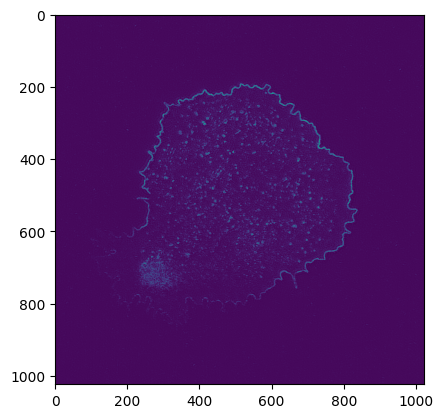

In [12]:
plt.imshow(image[2])

29.0 4.300000000000001 0.8028169014084507


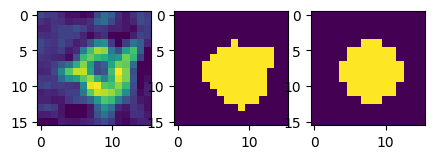

36.0 5.4 0.7244897959183674


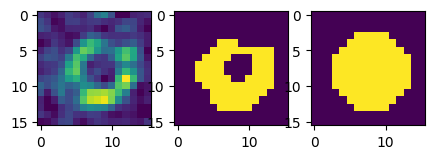

44.0 2.9000000000000004 0.7931034482758621


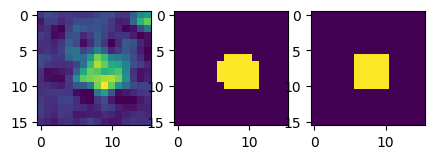

56.0 3.7 0.75


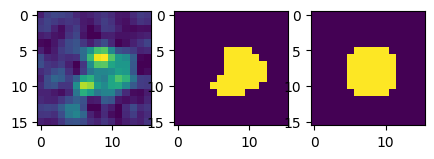

69.0 3.0 0.84375


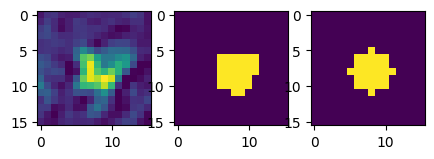

94.0 3.2 0.868421052631579


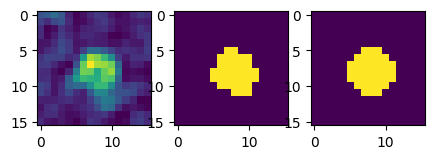

97.0 3.2 0.7560975609756098


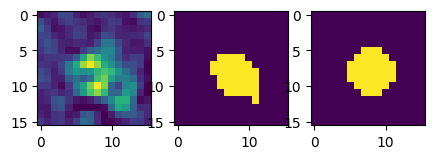

108.0 3.7 0.7272727272727273


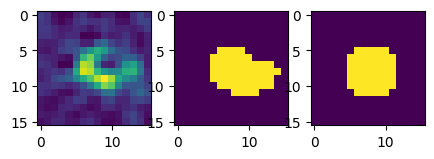

134.0 3.2 0.8918918918918919


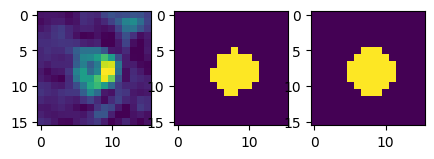

144.0 2.9000000000000004 0.8214285714285714


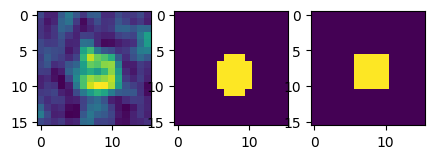

147.0 2.9000000000000004 0.8214285714285714


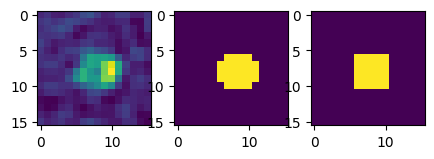

167.0 3.0 0.7878787878787878


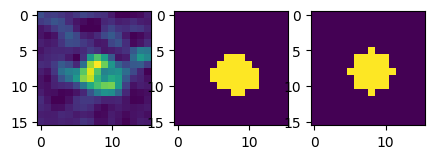

168.0 3.2 0.7209302325581395


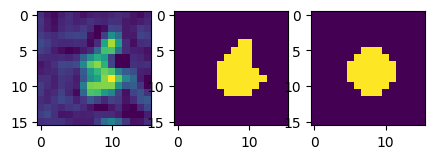

172.0 3.2 0.7380952380952381


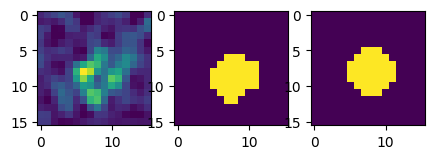

213.0 4.300000000000001 0.7464788732394366


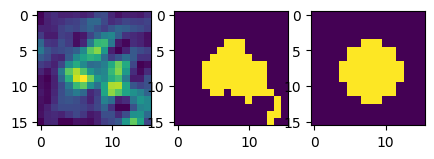

230.0 3.2 0.7317073170731707


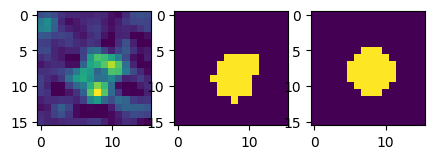

231.0 3.2 0.717948717948718


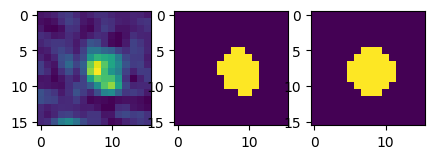

235.0 3.2 0.8648648648648649


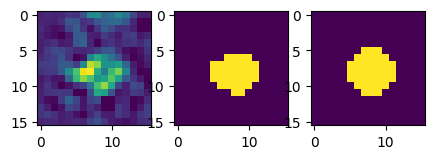

238.0 3.7 0.7608695652173914


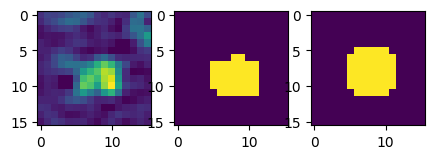

252.0 3.2 0.717391304347826


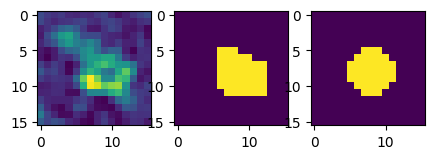

263.0 3.7 0.7142857142857143


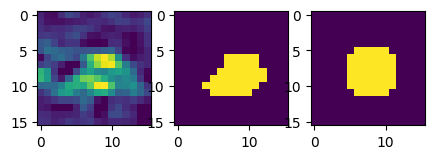

264.0 3.7 0.7450980392156863


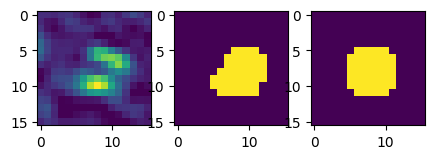

296.0 2.9000000000000004 0.7931034482758621


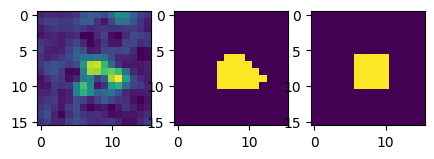

305.0 3.2 0.75


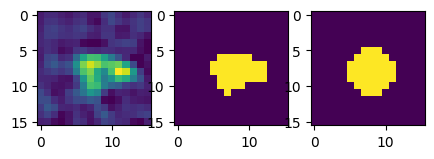

2.0 3.0 0.75


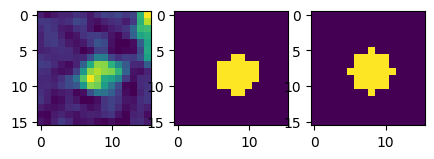

9.0 3.0 0.7647058823529411


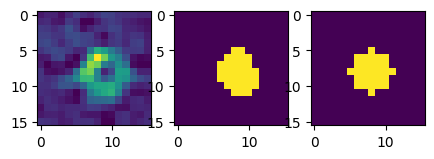

43.0 3.2 0.723404255319149


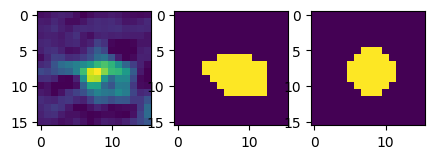

50.0 4.2 0.7166666666666667


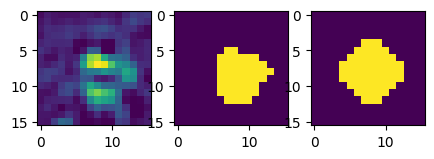

59.0 3.2 0.7948717948717948


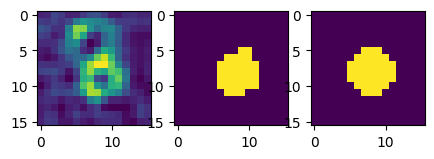

69.0 3.2 0.8


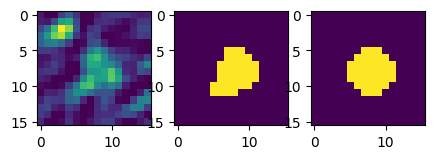

103.0 4.0 0.7962962962962963


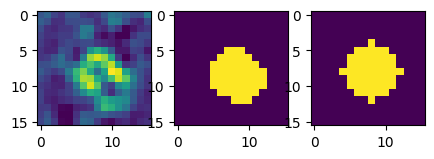

111.0 3.2 0.75


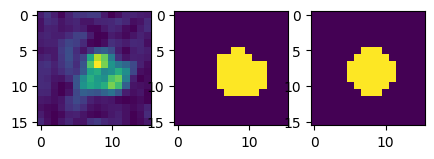

123.0 4.5 0.7368421052631579


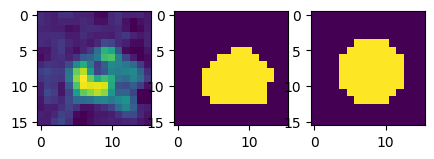

132.0 3.0 0.7647058823529411


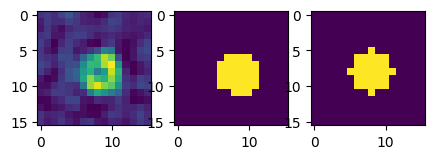

137.0 3.0 0.7352941176470589


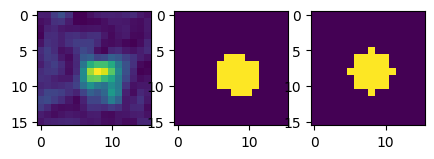

158.0 4.0 0.7272727272727273


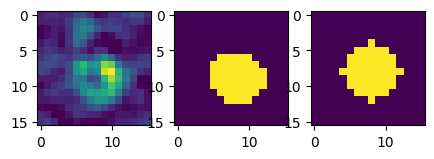

178.0 3.0 0.7647058823529411


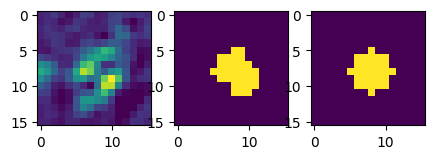

189.0 3.2 0.7804878048780488


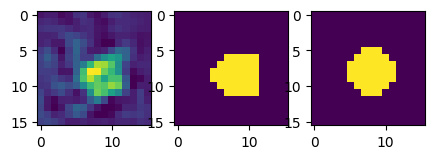

211.0 3.2 0.7857142857142857


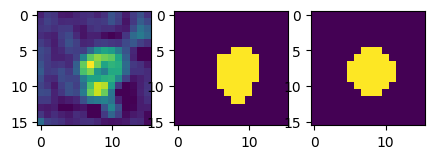

260.0 3.7 0.723404255319149


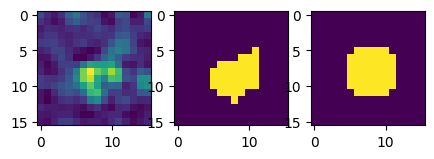

262.0 3.2 0.775


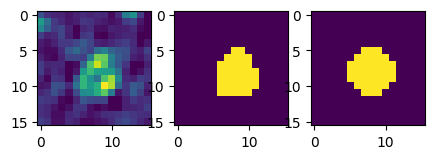

264.0 3.0 0.7352941176470589


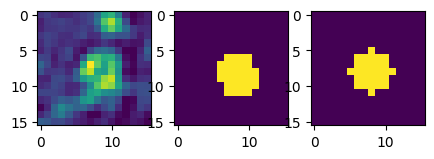

268.0 3.0 0.7575757575757576


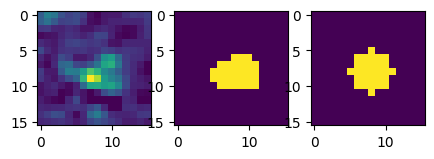

283.0 3.2 0.75


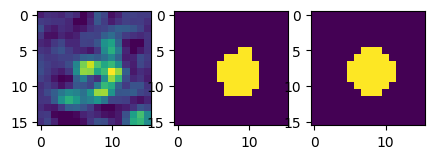

288.0 3.2 0.8205128205128205


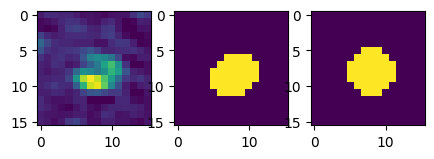

292.0 3.2 0.7391304347826086


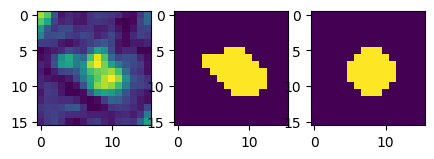

306.0 3.7 0.8431372549019608


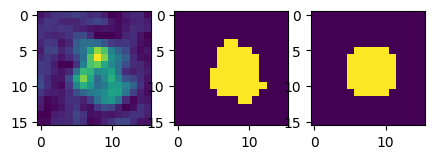

332.0 3.2 0.8378378378378378


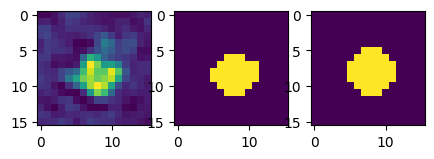

35.0 3.7 0.8163265306122449


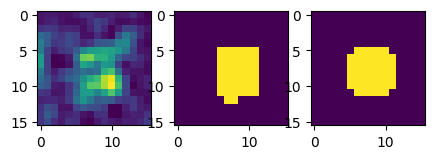

59.0 3.7 0.723404255319149


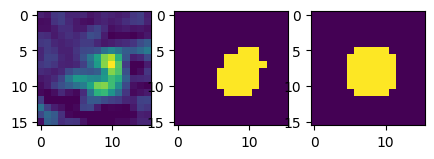

64.0 3.2 0.7906976744186046


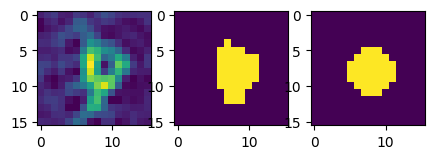

67.0 3.7 0.7291666666666666


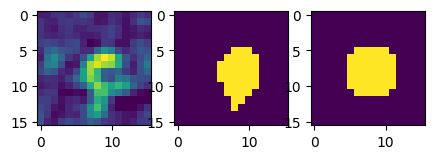

69.0 4.0 0.7166666666666667


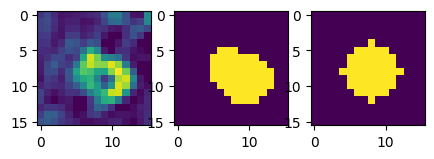

96.0 3.7 0.7777777777777778


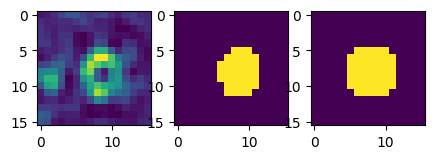

110.0 3.0 0.7878787878787878


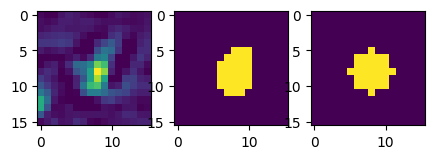

125.0 4.5 0.7160493827160493


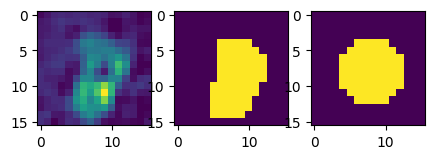

132.0 3.2 0.7567567567567568


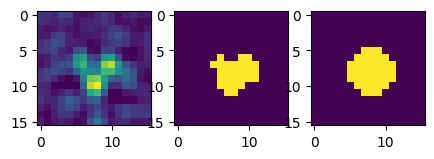

154.0 3.2 0.723404255319149


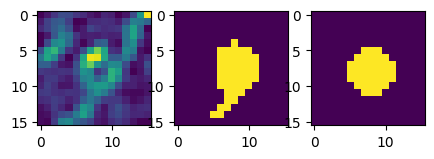

155.0 3.0 0.75


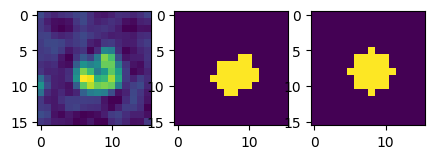

184.0 3.0 0.8064516129032258


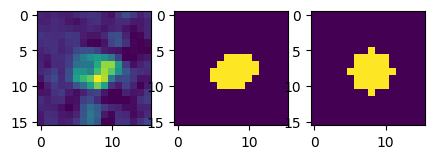

207.0 3.2 0.7560975609756098


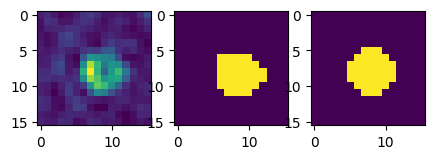

225.0 3.2 0.868421052631579


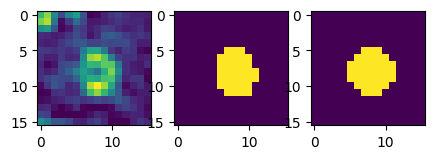

227.0 3.0 0.7297297297297297


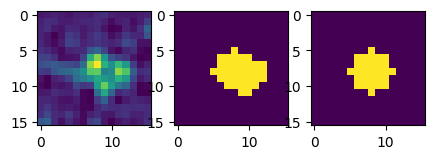

231.0 3.2 0.7105263157894737


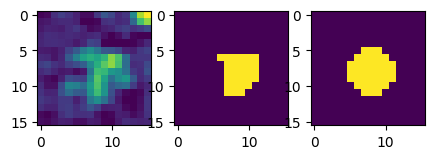

238.0 3.2 0.8


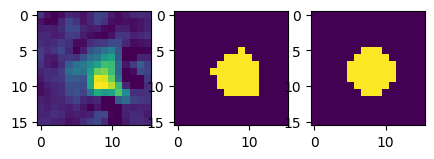

271.0 3.2 0.75


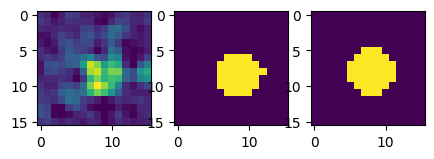

275.0 3.2 0.8421052631578947


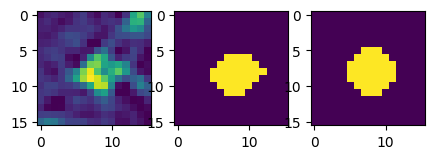

293.0 3.0 0.7878787878787878


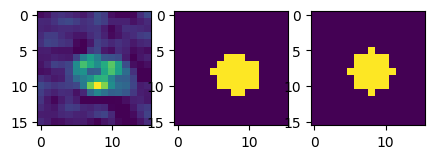

296.0 3.2 0.8461538461538461


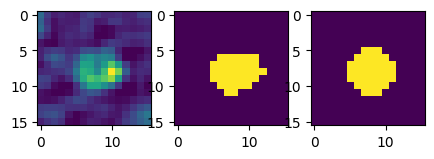

306.0 2.9000000000000004 0.7931034482758621


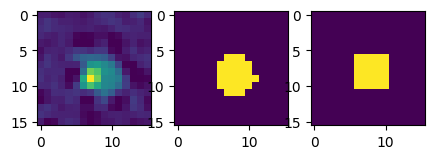

In [13]:
rings = pd.DataFrame()
opt_threshold = 180
for i in range(image.shape[0]):
    prop, label_mask_clean = idr.seg_cells(image[i], opt_threshold, 1.2, 25, 100, False)
    features = pd.DataFrame()
    for j in range(len(prop)): 
        y_center, x_center = prop[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
#         plt.text(x_center, y_center, str(j), fontweight = 'bold', color = 'white',size = 5)

        features = features.append([{'label':prop[j].label,'x': prop[j].centroid[0],
                                     'y': prop[j].centroid[1],'length': prop[j].major_axis_length,'frame': i}])
    results = idr.ring_fitting(image[i], label_mask_clean, features, 8, 0.71, True)
    if "intensity" in results:
        rings = rings.append(results[results.intensity>0])
rings['final_intensity'] = rings['intensity'] - rings['background']


In [14]:
normalize_by_cell(rings,"r","final_intensity")

,index,label,x,y,length,frame,r,score,intensity,background,area,perimeter,diameter(nm),length(um),final_intensity,nor_intensity,nor_length
3,0,29,288.223881,421.641791,9.830709,0,4.3,0.802817,17742.328125,2789.573535,58.088048,27.017697,344.0,1080.707873,14952.754590,0.774656,0.796296
7,0,36,298.638889,471.166667,11.889245,0,5.4,0.724490,23589.582031,4287.137308,91.608842,33.929201,432.0,1357.168026,19302.444723,1.000000,1.000000
10,0,44,307.074074,683.592593,6.421501,0,2.9,0.793103,7063.435547,1547.936665,26.420794,18.221237,232.0,728.849496,5515.498882,0.285741,0.537037
12,0,56,330.128205,605.769231,8.064868,0,3.7,0.750000,11483.662109,2498.991609,43.008403,23.247786,296.0,929.911425,8984.670500,0.465468,0.685185
15,0,69,354.100000,363.333333,6.562604,0,3.0,0.843750,8508.207031,1583.727986,28.274334,18.849556,240.0,753.982237,6924.479046,0.358736,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,271,576.484848,687.606061,6.683175,2,3.2,0.750000,10058.577148,2260.889395,32.169909,20.106193,256.0,804.247719,7797.687753,0.403974,0.592593
58,0,275,580.363636,586.272727,7.281161,2,3.2,0.842105,11497.721680,2574.119829,32.169909,20.106193,256.0,804.247719,8923.601851,0.462304,0.592593
60,0,293,604.400000,701.333333,6.760181,2,3.0,0.787879,8359.074219,1501.904659,28.274334,18.849556,240.0,753.982237,6857.169560,0.355249,0.555556
61,0,296,609.114286,545.171429,7.728924,2,3.2,0.846154,12348.806641,2325.237434,32.169909,20.106193,256.0,804.247719,10023.569206,0.519290,0.592593


# Generate plots

In [15]:
g1 = pd.read_csv(PATH + 'csv_data/g1.csv',index_col= 0)
g2 = pd.read_csv(PATH + 'csv_data/g2.csv',index_col= 0)
g3 = pd.read_csv(PATH + 'csv_data/g3.csv',index_col= 0)
g4 = pd.read_csv(PATH + 'csv_data/g4.csv',index_col= 0)

In [16]:
rings_result = g1
rings_result = rings_result.append(g2)
rings_result = rings_result.append(g3)
rings_result = rings_result.append(g4)

In [17]:
mean_rings,std_rings,diameter_rings = CalMean(rings_result,'nor_length',20)

In [18]:
mean_rings_g1,std_rings_g1,diameter_rings_g1 = CalMean(g1,'nor_length',20)
mean_rings_g2,std_rings_g2,diameter_rings_g2 = CalMean(g2,'nor_length',20)
mean_rings_g3,std_rings_g3,diameter_rings_g3 = CalMean(g3,'nor_length',20)
mean_rings_g4,std_rings_g4,diameter_rings_g4 = CalMean(g4,'nor_length',20)

In [19]:
popt, pcov = curve_fit(f_x, rings_result['nor_length'], rings_result.nor_intensity) # your data x, y to fit

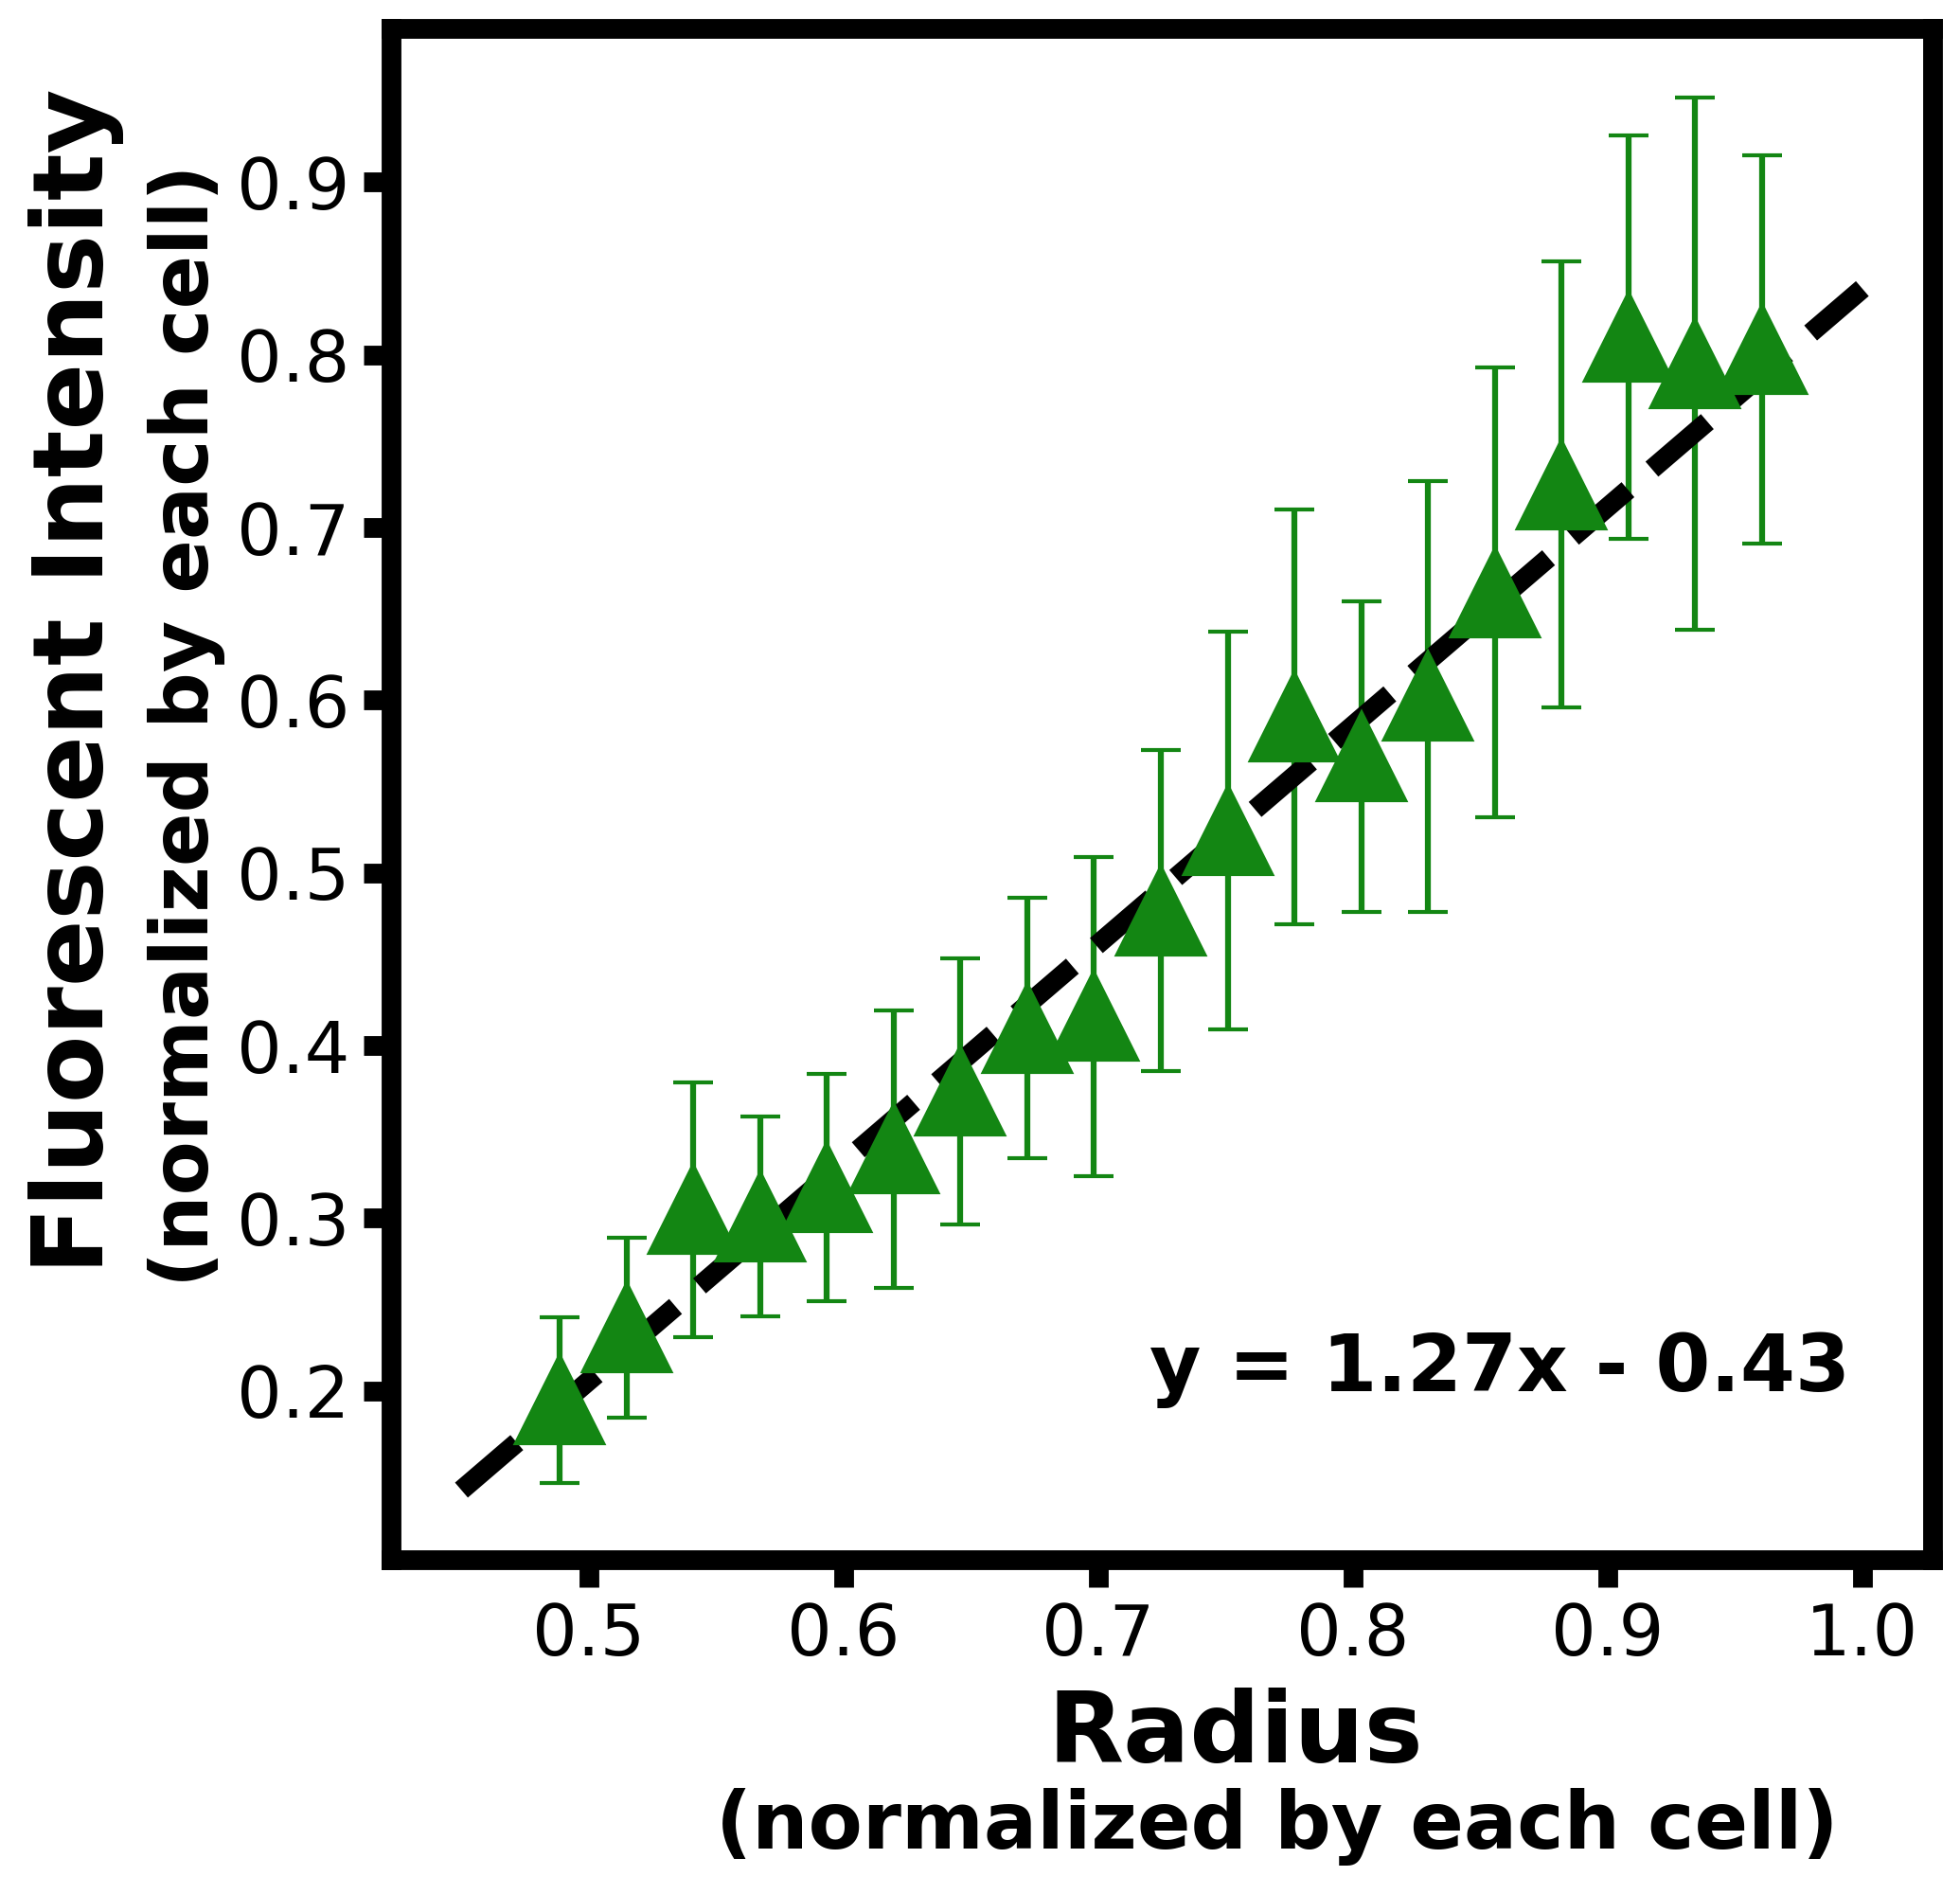

In [20]:
_,ax = plt.subplots(figsize = (7,7),dpi = 300)
plt.errorbar(diameter_rings, mean_rings, std_rings, linestyle='None',capsize = 5, marker='^',markersize = 22,color = '#138613')
x = np.linspace(0.45,1,20)
plt.plot(x,f_x(x,popt[0],popt[1]),ls = 'dashed',color = 'black',lw = 5)
plt.text(0.28,0.28,'Fluorescent Intensity',size= 25,rotation = 'vertical',fontweight = 'bold')
plt.text(0.327,0.27,'(normalized by each cell)',size= 20,rotation = 'vertical',fontweight = 'bold')
plt.text(0.68,-0.015,'Radius',size= 25,fontweight = 'bold')
plt.text(0.55,-0.065,'(normalized by each cell)',size= 20,fontweight = 'bold')
plt.text(0.72,0.2,'y = ' + "{:.2f}x - {:.2f}".format(popt[0],-popt[1]),size = 20,fontweight = 'bold')
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)

# increase tick width
ax.tick_params(width=5,size = 7)
plt.yticks(size = 18)
plt.xticks(size = 18)
plt.savefig(PATH + "Fig2G_nanorings.png",bbox_inches = 'tight',dpi = 300)